# Facial Keypoint Detection


## Initialize environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Convolution2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPool2D
from tensorflow.keras.optimizers import Nadam
from keras import backend
import os, gc, json, math

Using TensorFlow backend.
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.2.4
1.13.1


In [3]:

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

0


In [4]:
if not os.path.exists('../output/'):
    os.makedirs('../output/model')
    os.makedirs('../output/history')
    
    
model_dir = "../output/model/"
history_dir = "../output/history/"

train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)

## Exploratory Data Analysis

In [5]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


Check missing values and replace NaN's with mean values in that column

In [6]:
train_data.isnull().any().value_counts()
columns_nan = train_data.columns[train_data.isna().any()].tolist()
train_data[columns_nan] = train_data[columns_nan].fillna(value=train_data[columns_nan].mean())

Create training vector with images and normalize thee

In [7]:

x_train = []
for i in range(train_data.shape[0]):
    image = train_data['Image'][i].split(' ')
    image = ['0' if x == '' else x for x in image]
    x_train.append(image)
    
x_train = np.array(x_train,dtype = 'float')
x_train = x_train/255.0
x_train = x_train.reshape(-1,96,96,1)
    

Display test image.

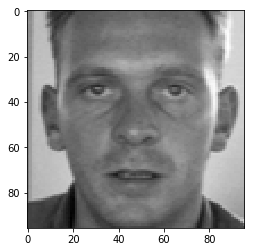

In [8]:
plt.imshow(x_train[2].reshape(96,96),cmap='gray')
plt.show()

Generate labels 

In [9]:

y_train = []
for i in range(train_data.shape[0]):
    label = train_data.iloc[i,0:30]
    y_train.append(label)
    
y_train = np.array(y_train,dtype = 'float')



In [10]:
# Define callback function if detailed log required
class History(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_rmse = []
        self.val_rmse = []
        self.val_loss = []

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_rmse.append(logs.get('rmse'))
        
    def on_epoch_end(self, batch, logs={}):    
        self.val_rmse.append(logs.get('val_rmse'))
        self.val_loss.append(logs.get('val_loss'))
        
# Implement ModelCheckPoint callback function to save CNN model
class CNN_ModelCheckpoint(tensorflow.keras.callbacks.Callback):

    def __init__(self, model, filename):
        self.filename = filename
        self.cnn_model = model

    def on_train_begin(self, logs={}):
        self.max_val_rmse = math.inf
        
 
    def on_epoch_end(self, batch, logs={}):    
        val_rmse = logs.get('val_rmse')
        if(val_rmse < self.max_val_rmse):
           self.max_val_rmse = val_rmse
           self.cnn_model.save(self.filename)


In [12]:
def base_model():
    model_input = Input(shape=(96,96,1))

    x = Convolution2D(32, (3,3), padding='same', use_bias=False)(model_input)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(64, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(96, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(128, (3,3),padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(256, (3,3),padding='same',use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(512, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.1)(x)
    model_output = Dense(30)(x)
    model = Model(model_input, model_output, name="base_model")
    return model

model = base_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 48, 48, 64)        0         
__________

In [13]:
# Custom RMSE metric
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

#from tensorflow.keras.optimizers.schedules import InverseTimeDecay

# Use Nadam optimizer with variable learning rate
optimizer = Nadam(lr=0.00001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)


# Loss: MSE and Metric = RMSE
model.compile(optimizer= optimizer, 
              loss='mean_squared_error',
              metrics=[rmse])

#Callback to save the best model
saveBase_Model = CNN_ModelCheckpoint(model, model_dir+"base_model.h5")

#define callback functions
callbacks = [#EarlyStopping(monitor='val_rmse', patience=3, verbose=2),
             saveBase_Model]

Instructions for updating:
Use tf.cast instead.


Run for 1000 epochs and keeping 20% train-valid split

In [14]:
history = model.fit(x_train,
                    y_train,
                    epochs = 1000,
                    batch_size = 256,
                    validation_split = 0.2,
                    callbacks = callbacks
                    )

Train on 5639 samples, validate on 1410 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
5639/5639 [==============================] - 9s 2ms/sample - loss: 2561.7874 - rmse: 50.5991 - val_loss: 2639.2998 - val_rmse: 51.3701
Epoch 2/1000
5639/5639 [==============================] - 3s 578us/sample - loss: 2343.3655 - rmse: 48.3862 - val_loss: 2641.0817 - val_rmse: 51.3874
Epoch 3/1000
5639/5639 [==============================] - 3s 609us/sample - loss: 2052.1429 - rmse: 45.2590 - val_loss: 2643.1272 - val_rmse: 51.4073
Epoch 4/1000
5639/5639 [==============================] - 3s 588us/sample - loss: 1718.9655 - rmse: 41.3909 - val_loss: 2640.0194 - val_rmse: 51.3771
Epoch 5/1000
5639/5639 [==============================] - 4s 666us/sample - loss: 1399.8333 - rmse: 37.3175 - val_loss: 2627.1129 - val_rmse: 51.2513
Epoch 6/1000
5639/5639 [==============================] - 4s 672us/sample - loss: 1114.5163 - rmse: 33.2527 - val_loss: 2595.4941 - val_rmse: 50.9419
Epoch 

Epoch 55/1000
5639/5639 [==============================] - 3s 546us/sample - loss: 33.0305 - rmse: 5.6084 - val_loss: 7.8274 - val_rmse: 2.4574
Epoch 56/1000
5639/5639 [==============================] - 3s 542us/sample - loss: 32.8056 - rmse: 5.5889 - val_loss: 7.4262 - val_rmse: 2.3942
Epoch 57/1000
5639/5639 [==============================] - 3s 542us/sample - loss: 32.8594 - rmse: 5.5975 - val_loss: 6.9819 - val_rmse: 2.3026
Epoch 58/1000
5639/5639 [==============================] - 3s 542us/sample - loss: 32.2573 - rmse: 5.5444 - val_loss: 8.5147 - val_rmse: 2.5819
Epoch 59/1000
5639/5639 [==============================] - 3s 568us/sample - loss: 32.0432 - rmse: 5.5290 - val_loss: 6.9453 - val_rmse: 2.2923
Epoch 60/1000
5639/5639 [==============================] - 3s 572us/sample - loss: 31.9215 - rmse: 5.5124 - val_loss: 6.8651 - val_rmse: 2.2857
Epoch 61/1000
5639/5639 [==============================] - 3s 597us/sample - loss: 31.9809 - rmse: 5.5161 - val_loss: 6.8767 - val_rmse:

Epoch 112/1000
5639/5639 [==============================] - 3s 567us/sample - loss: 25.3650 - rmse: 4.9056 - val_loss: 5.8172 - val_rmse: 2.0988
Epoch 113/1000
5639/5639 [==============================] - 3s 541us/sample - loss: 25.2329 - rmse: 4.8915 - val_loss: 6.4229 - val_rmse: 2.2362
Epoch 114/1000
5639/5639 [==============================] - 3s 537us/sample - loss: 25.1260 - rmse: 4.8751 - val_loss: 5.7216 - val_rmse: 2.0803
Epoch 115/1000
5639/5639 [==============================] - 3s 535us/sample - loss: 24.8596 - rmse: 4.8542 - val_loss: 5.9939 - val_rmse: 2.1388
Epoch 116/1000
5639/5639 [==============================] - 3s 530us/sample - loss: 24.9050 - rmse: 4.8572 - val_loss: 5.7912 - val_rmse: 2.0982
Epoch 117/1000
5639/5639 [==============================] - 3s 531us/sample - loss: 24.8553 - rmse: 4.8497 - val_loss: 5.5755 - val_rmse: 2.0497
Epoch 118/1000
5639/5639 [==============================] - 3s 531us/sample - loss: 24.9591 - rmse: 4.8603 - val_loss: 5.5859 - va

5639/5639 [==============================] - 3s 529us/sample - loss: 20.0987 - rmse: 4.3568 - val_loss: 5.8545 - val_rmse: 2.1367
Epoch 169/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 19.9523 - rmse: 4.3338 - val_loss: 5.3313 - val_rmse: 2.0192
Epoch 170/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 19.9596 - rmse: 4.3403 - val_loss: 5.7155 - val_rmse: 2.1127
Epoch 171/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 19.6260 - rmse: 4.3025 - val_loss: 5.2830 - val_rmse: 2.0084
Epoch 172/1000
5639/5639 [==============================] - 3s 559us/sample - loss: 19.6598 - rmse: 4.3085 - val_loss: 4.6336 - val_rmse: 1.8498
Epoch 173/1000
5639/5639 [==============================] - 3s 532us/sample - loss: 19.6136 - rmse: 4.2995 - val_loss: 4.7811 - val_rmse: 1.8850
Epoch 174/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 19.4775 - rmse: 4.2897 - val_loss: 6.3065 - val_rmse: 2.2433


5639/5639 [==============================] - 3s 526us/sample - loss: 15.8697 - rmse: 3.8653 - val_loss: 4.5473 - val_rmse: 1.8523
Epoch 225/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 15.8263 - rmse: 3.8578 - val_loss: 4.7241 - val_rmse: 1.8888
Epoch 226/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 15.8898 - rmse: 3.8684 - val_loss: 4.4804 - val_rmse: 1.8352
Epoch 227/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 15.7461 - rmse: 3.8480 - val_loss: 5.0554 - val_rmse: 1.9797
Epoch 228/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 15.6372 - rmse: 3.8373 - val_loss: 5.9148 - val_rmse: 2.1790
Epoch 229/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 15.5063 - rmse: 3.8193 - val_loss: 4.6518 - val_rmse: 1.8820
Epoch 230/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 15.4810 - rmse: 3.8169 - val_loss: 5.4202 - val_rmse: 2.0717


5639/5639 [==============================] - 3s 528us/sample - loss: 12.9200 - rmse: 3.4817 - val_loss: 4.2043 - val_rmse: 1.7719
Epoch 281/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 12.9022 - rmse: 3.4826 - val_loss: 5.0419 - val_rmse: 1.9781
Epoch 282/1000
5639/5639 [==============================] - 3s 569us/sample - loss: 12.8018 - rmse: 3.4685 - val_loss: 4.1116 - val_rmse: 1.7473
Epoch 283/1000
5639/5639 [==============================] - 3s 532us/sample - loss: 12.7294 - rmse: 3.4597 - val_loss: 4.6822 - val_rmse: 1.8935
Epoch 284/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 12.6949 - rmse: 3.4503 - val_loss: 5.1719 - val_rmse: 2.0228
Epoch 285/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 12.5367 - rmse: 3.4320 - val_loss: 4.2885 - val_rmse: 1.7957
Epoch 286/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 12.6262 - rmse: 3.4414 - val_loss: 4.1879 - val_rmse: 1.7695


5639/5639 [==============================] - 3s 526us/sample - loss: 10.5334 - rmse: 3.1445 - val_loss: 4.2610 - val_rmse: 1.7981
Epoch 337/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 10.4496 - rmse: 3.1316 - val_loss: 4.4219 - val_rmse: 1.8402
Epoch 338/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 10.4599 - rmse: 3.1317 - val_loss: 4.0247 - val_rmse: 1.7293
Epoch 339/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 10.3930 - rmse: 3.1176 - val_loss: 6.1727 - val_rmse: 2.2597
Epoch 340/1000
5639/5639 [==============================] - 3s 541us/sample - loss: 10.4487 - rmse: 3.1278 - val_loss: 4.4199 - val_rmse: 1.8347
Epoch 341/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 10.3979 - rmse: 3.1208 - val_loss: 4.0203 - val_rmse: 1.7336
Epoch 342/1000
5639/5639 [==============================] - 3s 532us/sample - loss: 10.3470 - rmse: 3.1151 - val_loss: 5.5650 - val_rmse: 2.1126


Epoch 393/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 8.7685 - rmse: 2.8671 - val_loss: 4.3598 - val_rmse: 1.8284
Epoch 394/1000
5639/5639 [==============================] - 3s 554us/sample - loss: 8.8707 - rmse: 2.8818 - val_loss: 3.8685 - val_rmse: 1.6949
Epoch 395/1000
5639/5639 [==============================] - 3s 530us/sample - loss: 8.7821 - rmse: 2.8683 - val_loss: 4.0571 - val_rmse: 1.7491
Epoch 396/1000
5639/5639 [==============================] - 3s 530us/sample - loss: 8.6920 - rmse: 2.8580 - val_loss: 5.8639 - val_rmse: 2.1878
Epoch 397/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 8.6907 - rmse: 2.8544 - val_loss: 5.0837 - val_rmse: 2.0144
Epoch 398/1000
5639/5639 [==============================] - 3s 530us/sample - loss: 8.6490 - rmse: 2.8449 - val_loss: 5.0488 - val_rmse: 1.9935
Epoch 399/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 8.6384 - rmse: 2.8470 - val_loss: 4.4545 - val_rmse:

Epoch 450/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 7.5874 - rmse: 2.6652 - val_loss: 3.8981 - val_rmse: 1.7082
Epoch 451/1000
5639/5639 [==============================] - 3s 530us/sample - loss: 7.4349 - rmse: 2.6428 - val_loss: 3.9771 - val_rmse: 1.7284
Epoch 452/1000
5639/5639 [==============================] - 3s 552us/sample - loss: 7.3998 - rmse: 2.6355 - val_loss: 3.8012 - val_rmse: 1.6796
Epoch 453/1000
5639/5639 [==============================] - 3s 533us/sample - loss: 7.3787 - rmse: 2.6299 - val_loss: 4.3647 - val_rmse: 1.8339
Epoch 454/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 7.3215 - rmse: 2.6199 - val_loss: 4.3037 - val_rmse: 1.8136
Epoch 455/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 7.3947 - rmse: 2.6327 - val_loss: 4.6978 - val_rmse: 1.9184
Epoch 456/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 7.3584 - rmse: 2.6261 - val_loss: 4.0709 - val_rmse:

Epoch 507/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 6.4249 - rmse: 2.4546 - val_loss: 5.0852 - val_rmse: 2.0165
Epoch 508/1000
5639/5639 [==============================] - 3s 557us/sample - loss: 6.4836 - rmse: 2.4641 - val_loss: 3.7581 - val_rmse: 1.6641
Epoch 509/1000
5639/5639 [==============================] - 3s 531us/sample - loss: 6.4189 - rmse: 2.4522 - val_loss: 3.9310 - val_rmse: 1.7128
Epoch 510/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 6.3843 - rmse: 2.4456 - val_loss: 3.7763 - val_rmse: 1.6729
Epoch 511/1000
5639/5639 [==============================] - 3s 525us/sample - loss: 6.3556 - rmse: 2.4440 - val_loss: 5.6784 - val_rmse: 2.1484
Epoch 512/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 6.4517 - rmse: 2.4553 - val_loss: 3.9387 - val_rmse: 1.7201
Epoch 513/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 6.3644 - rmse: 2.4410 - val_loss: 6.7651 - val_rmse:

Epoch 564/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 5.7512 - rmse: 2.3201 - val_loss: 3.9001 - val_rmse: 1.7147
Epoch 565/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 5.6739 - rmse: 2.3032 - val_loss: 4.1926 - val_rmse: 1.7859
Epoch 566/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 5.6937 - rmse: 2.3089 - val_loss: 4.4657 - val_rmse: 1.8609
Epoch 567/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 5.6952 - rmse: 2.3103 - val_loss: 3.8657 - val_rmse: 1.6968
Epoch 568/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 5.5910 - rmse: 2.2908 - val_loss: 4.8918 - val_rmse: 1.9681
Epoch 569/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 5.6876 - rmse: 2.3062 - val_loss: 3.9917 - val_rmse: 1.7363
Epoch 570/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 5.6240 - rmse: 2.2916 - val_loss: 3.8812 - val_rmse:

Epoch 621/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 5.0951 - rmse: 2.1832 - val_loss: 3.7761 - val_rmse: 1.6744
Epoch 622/1000
5639/5639 [==============================] - 3s 538us/sample - loss: 5.0951 - rmse: 2.1836 - val_loss: 4.2741 - val_rmse: 1.8127
Epoch 623/1000
5639/5639 [==============================] - 3s 531us/sample - loss: 5.1032 - rmse: 2.1812 - val_loss: 3.7262 - val_rmse: 1.6598
Epoch 624/1000
5639/5639 [==============================] - 3s 554us/sample - loss: 5.0844 - rmse: 2.1786 - val_loss: 3.6430 - val_rmse: 1.6350
Epoch 625/1000
5639/5639 [==============================] - 3s 535us/sample - loss: 5.0747 - rmse: 2.1776 - val_loss: 4.0417 - val_rmse: 1.7530
Epoch 626/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 5.0618 - rmse: 2.1763 - val_loss: 4.1672 - val_rmse: 1.7761
Epoch 627/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 5.0731 - rmse: 2.1784 - val_loss: 5.6269 - val_rmse:

Epoch 678/1000
5639/5639 [==============================] - 3s 523us/sample - loss: 4.6872 - rmse: 2.0846 - val_loss: 3.8591 - val_rmse: 1.6950
Epoch 679/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 4.6745 - rmse: 2.0865 - val_loss: 3.9257 - val_rmse: 1.7160
Epoch 680/1000
5639/5639 [==============================] - 3s 531us/sample - loss: 4.6355 - rmse: 2.0787 - val_loss: 4.0588 - val_rmse: 1.7517
Epoch 681/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 4.6150 - rmse: 2.0761 - val_loss: 3.9277 - val_rmse: 1.7120
Epoch 682/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 4.5564 - rmse: 2.0609 - val_loss: 4.4659 - val_rmse: 1.8584
Epoch 683/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 4.6169 - rmse: 2.0744 - val_loss: 4.2648 - val_rmse: 1.8137
Epoch 684/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 4.6365 - rmse: 2.0773 - val_loss: 5.3798 - val_rmse:

Epoch 735/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 4.3134 - rmse: 1.9989 - val_loss: 4.5206 - val_rmse: 1.8796
Epoch 736/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 4.3535 - rmse: 2.0066 - val_loss: 3.7253 - val_rmse: 1.6590
Epoch 737/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 4.2785 - rmse: 1.9930 - val_loss: 5.1363 - val_rmse: 2.0336
Epoch 738/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 4.2991 - rmse: 1.9971 - val_loss: 4.6447 - val_rmse: 1.9056
Epoch 739/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 4.2950 - rmse: 1.9941 - val_loss: 3.5839 - val_rmse: 1.6194
Epoch 740/1000
5639/5639 [==============================] - 3s 542us/sample - loss: 4.2397 - rmse: 1.9830 - val_loss: 4.6767 - val_rmse: 1.9154
Epoch 741/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 4.2777 - rmse: 1.9912 - val_loss: 3.5740 - val_rmse:

Epoch 792/1000
5639/5639 [==============================] - 3s 530us/sample - loss: 3.9360 - rmse: 1.9110 - val_loss: 4.0711 - val_rmse: 1.7556
Epoch 793/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 3.9078 - rmse: 1.9021 - val_loss: 3.6266 - val_rmse: 1.6293
Epoch 794/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 3.9414 - rmse: 1.9085 - val_loss: 3.5735 - val_rmse: 1.6142
Epoch 795/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 3.8915 - rmse: 1.8980 - val_loss: 4.0141 - val_rmse: 1.7416
Epoch 796/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 3.9442 - rmse: 1.9084 - val_loss: 3.6681 - val_rmse: 1.6409
Epoch 797/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 3.8737 - rmse: 1.8977 - val_loss: 3.8459 - val_rmse: 1.6836
Epoch 798/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 3.9299 - rmse: 1.9097 - val_loss: 3.5914 - val_rmse:

Epoch 849/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 3.6804 - rmse: 1.8425 - val_loss: 3.6184 - val_rmse: 1.6230
Epoch 850/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 3.6361 - rmse: 1.8307 - val_loss: 4.2361 - val_rmse: 1.7981
Epoch 851/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 3.7177 - rmse: 1.8501 - val_loss: 3.6786 - val_rmse: 1.6357
Epoch 852/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 3.6561 - rmse: 1.8390 - val_loss: 3.5397 - val_rmse: 1.5977
Epoch 853/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 3.6424 - rmse: 1.8349 - val_loss: 3.5384 - val_rmse: 1.6020
Epoch 854/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 3.6306 - rmse: 1.8306 - val_loss: 3.8262 - val_rmse: 1.6832
Epoch 855/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 3.6455 - rmse: 1.8347 - val_loss: 3.8853 - val_rmse:

Epoch 906/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 3.4812 - rmse: 1.7880 - val_loss: 4.4837 - val_rmse: 1.8682
Epoch 907/1000
5639/5639 [==============================] - 3s 524us/sample - loss: 3.4267 - rmse: 1.7728 - val_loss: 3.8388 - val_rmse: 1.6844
Epoch 908/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 3.4545 - rmse: 1.7814 - val_loss: 3.6709 - val_rmse: 1.6366
Epoch 909/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 3.4388 - rmse: 1.7759 - val_loss: 3.5144 - val_rmse: 1.5945
Epoch 910/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 3.4363 - rmse: 1.7775 - val_loss: 5.7384 - val_rmse: 2.1810
Epoch 911/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 3.5084 - rmse: 1.7913 - val_loss: 3.9488 - val_rmse: 1.7191
Epoch 912/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 3.4277 - rmse: 1.7728 - val_loss: 3.8723 - val_rmse:

Epoch 963/1000
5639/5639 [==============================] - 3s 529us/sample - loss: 3.2259 - rmse: 1.7183 - val_loss: 3.5399 - val_rmse: 1.5957
Epoch 964/1000
5639/5639 [==============================] - 3s 526us/sample - loss: 3.2585 - rmse: 1.7236 - val_loss: 3.6889 - val_rmse: 1.6443
Epoch 965/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 3.1988 - rmse: 1.7120 - val_loss: 3.6876 - val_rmse: 1.6384
Epoch 966/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 3.1948 - rmse: 1.7087 - val_loss: 3.4811 - val_rmse: 1.5791
Epoch 967/1000
5639/5639 [==============================] - 3s 527us/sample - loss: 3.2208 - rmse: 1.7203 - val_loss: 3.4932 - val_rmse: 1.5809
Epoch 968/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 3.2037 - rmse: 1.7104 - val_loss: 4.0714 - val_rmse: 1.7529
Epoch 969/1000
5639/5639 [==============================] - 3s 528us/sample - loss: 3.2237 - rmse: 1.7176 - val_loss: 3.6906 - val_rmse:

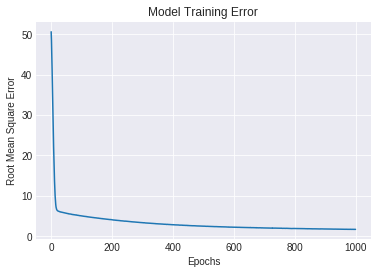

In [15]:
plt.style.use('seaborn-darkgrid')
plt.plot(history.history['rmse'])
plt.xlabel('Epochs')
plt.ylabel('Root Mean Square Error')
plt.title('Model Training Error')
plt.show()

In [16]:
sess = get_session()
clear_session()
sess.close()
sess = get_session()
try:
    del model # this is from global space - change this as you need
except:
    print("Model clear Failed")
print(gc.collect())    

2211
